In [ ]:
import pandas as pd
import numpy as np
import time
from pprint import pprint

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, roc_auc_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
from sklearn.pipeline import Pipeline

import sys
sys.path.append('../')
from backtest_functions_v2 import *

In [2]:
# Load the latest dataset
df = pd.read_parquet("../data/full_dataset_feature_engineering_v3.parquet")
print("Dataset loaded successfully.")
df.info()

Dataset loaded successfully.
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 35058 entries, 2021-01-01 06:00:00 to 2024-12-31 23:00:00
Columns: 149 entries, news_count to reddit_average_sentiment_ewm_100h
dtypes: float64(87), int32(1), int64(61)
memory usage: 40.0 MB


### Data Preparation and Splitting

In [3]:
# Use all features except target and forward return
all_features = df.columns.drop(['target', 'return_forward'])
print(f"Number of features: {len(all_features)}")

# Define training (2021-2023) and testing (2024) periods
df_train = df[df['year'].isin([2021, 2022, 2023])]
df_test = df[df['year'] == 2024]

X_train = df_train[all_features]
y_train = df_train['target']
X_test = df_test[all_features]
y_test = df_test['target']

# Print shapes and class distribution
print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_test shape: {y_test.shape}")
print(f"Training set class distribution: {np.bincount(y_train)}")
print(f"Test set class distribution: {np.bincount(y_test)}")

Number of features: 147
X_train shape: (26274, 147)
y_train shape: (26274,)
X_test shape: (8784, 147)
y_test shape: (8784,)
Training set class distribution: [ 9993  6038 10243]
Test set class distribution: [2648 3274 2862]


### RandomForestClassifier Model with GridSearchCV

In [4]:
# Define the pipeline with StandardScaler and RandomForestClassifier
pipeline = Pipeline([
  ('scaler', StandardScaler()),
  ('model', RandomForestClassifier(
    random_state=42,
    class_weight='balanced_subsample', # Good for imbalanced data with RF
    n_jobs=-1 # Use all cores for fitting individual trees
  ))
])

# Parameter grid for GridSearchCV - Start with a smaller grid for reasonable runtime
param_grid = {
  'model__n_estimators': [100, 200],        # Number of trees
  'model__max_depth': [10, 20, None],       # Max depth of trees
  'model__min_samples_split': [5, 10],      # Min samples to split a node
  'model__min_samples_leaf': [3, 5]         # Min samples in a leaf node
}

# Time series cross-validation
tscv = TimeSeriesSplit(n_splits=5)

# Initialize GridSearchCV
grid_search = GridSearchCV(
  estimator=pipeline,
  param_grid=param_grid,
  cv=tscv,
  scoring='roc_auc_ovr', # Use One-vs-Rest ROC AUC for multiclass
  n_jobs=-1,             # Use all available CPU cores for CV folds
  verbose=2              # Show progress
)

# Fit GridSearchCV on the training data
print("Starting GridSearchCV for RandomForestClassifier...")
start_time = time.time()
grid_search.fit(X_train, y_train)
end_time = time.time()

print(f"\nGridSearchCV fitting time: {end_time - start_time:.2f} seconds")
print("Best parameters found: ", grid_search.best_params_)
print("Best cross-validation ROC AUC score: ", grid_search.best_score_)

# Get the best estimator found by GridSearchCV
best_model = grid_search.best_estimator_

Starting GridSearchCV for RandomForestClassifier...
Fitting 5 folds for each of 24 candidates, totalling 120 fits

GridSearchCV fitting time: 232.72 seconds
Best parameters found:  {'model__max_depth': 10, 'model__min_samples_leaf': 3, 'model__min_samples_split': 10, 'model__n_estimators': 200}
Best cross-validation ROC AUC score:  0.5860791265041005


### Feature Importance Analysis


Top 20 most important features:
                    Feature  Importance
47                    atr_7    0.057850
48                   atr_14    0.052082
66            10_band_width    0.048204
68            20_band_width    0.037388
55                atr_ratio    0.020678
19    ema_5_20_diff_abs_chg    0.018769
60            upper_band_10    0.015752
21   ema_20_50_diff_abs_chg    0.014666
56     trailing_stop_long_7    0.013853
49              atr_7_slope    0.013710
70                     year    0.012986
67                 pct_b_10    0.012931
62            lower_band_10    0.012765
51             atr_14_slope    0.012724
52               atr_14_chg    0.012526
63            upper_band_20    0.012504
23  ema_50_200_diff_abs_chg    0.012189
58    trailing_stop_short_7    0.011745
38                    rsi_7    0.011621
10            ema_5_20_diff    0.011566


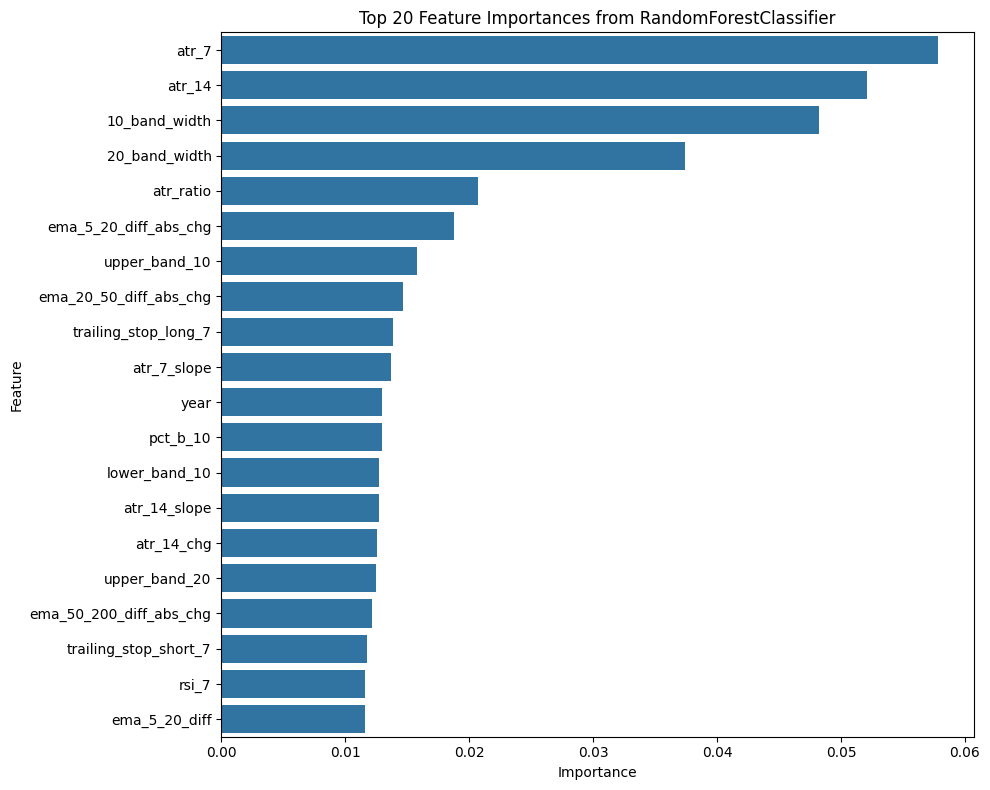

In [5]:
# Get feature importances from the best RandomForest model
importances = best_model.named_steps['model'].feature_importances_
feature_names = X_train.columns

# Create a DataFrame for feature importances
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
})

# Sort by importance
importance_df = importance_df.sort_values(by='Importance', ascending=False)

print("\nTop 20 most important features:")
print(importance_df.head(20))

# Plot top 20 feature importances
plt.figure(figsize=(10, 8))
sns.barplot(x='Importance', y='Feature', data=importance_df.head(20))
plt.title('Top 20 Feature Importances from RandomForestClassifier')
plt.tight_layout()
plt.show()

### Model Evaluation on Test Set


Predicting on the test set...
Prediction complete.

Test Set Evaluation:
Accuracy: 0.4730
ROC AUC Score (One-vs-Rest): 0.6785

Classification Report:
              precision    recall  f1-score   support

 Bearish (0)       0.37      0.60      0.46      2648
 Neutral (1)       0.78      0.42      0.55      3274
 Bullish (2)       0.44      0.41      0.42      2862

    accuracy                           0.47      8784
   macro avg       0.53      0.48      0.48      8784
weighted avg       0.54      0.47      0.48      8784


Confusion Matrix:
[[1600  189  859]
 [1263 1386  625]
 [1481  212 1169]]


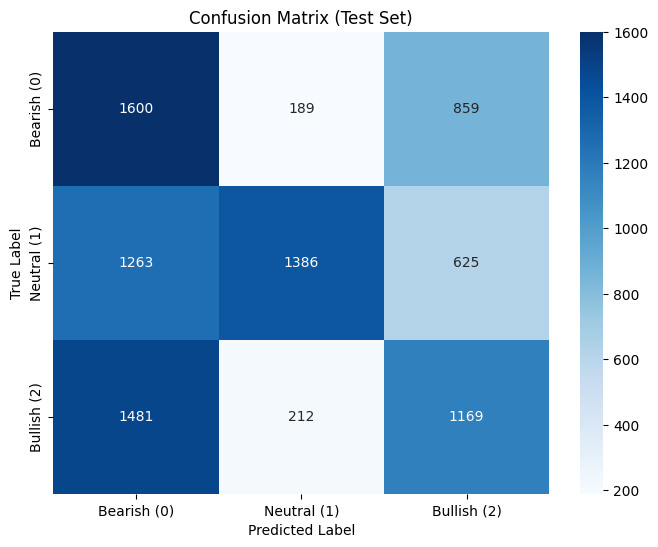

In [6]:
# Make predictions on the test set
print("\nPredicting on the test set...")
y_pred = best_model.predict(X_test)
y_pred_proba = best_model.predict_proba(X_test)
print("Prediction complete.")

# Evaluate the model performance on the test set
accuracy = accuracy_score(y_test, y_pred)
class_names = ['Bearish (0)', 'Neutral (1)', 'Bullish (2)']
report = classification_report(y_test, y_pred, target_names=class_names)
conf_matrix = confusion_matrix(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_proba, multi_class='ovr')

print(f"\nTest Set Evaluation:")
print(f"Accuracy: {accuracy:.4f}")
print(f"ROC AUC Score (One-vs-Rest): {roc_auc:.4f}")
print("\nClassification Report:")
print(report)
print("\nConfusion Matrix:")
print(conf_matrix)

# Plot confusion matrix with labels
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix (Test Set)')
plt.show()

### Monthly Accuracy Analysis


Monthly Accuracy (2024 Test Set):
2024-01-31    0.416667
2024-02-29    0.455460
2024-03-31    0.430108
2024-04-30    0.440278
2024-05-31    0.420699
2024-06-30    0.455556
2024-07-31    0.396505
2024-08-31    0.412634
2024-09-30    0.544444
2024-10-31    0.685484
2024-11-30    0.513889
2024-12-31    0.505376
Freq: ME, Name: correct_prediction, dtype: float64


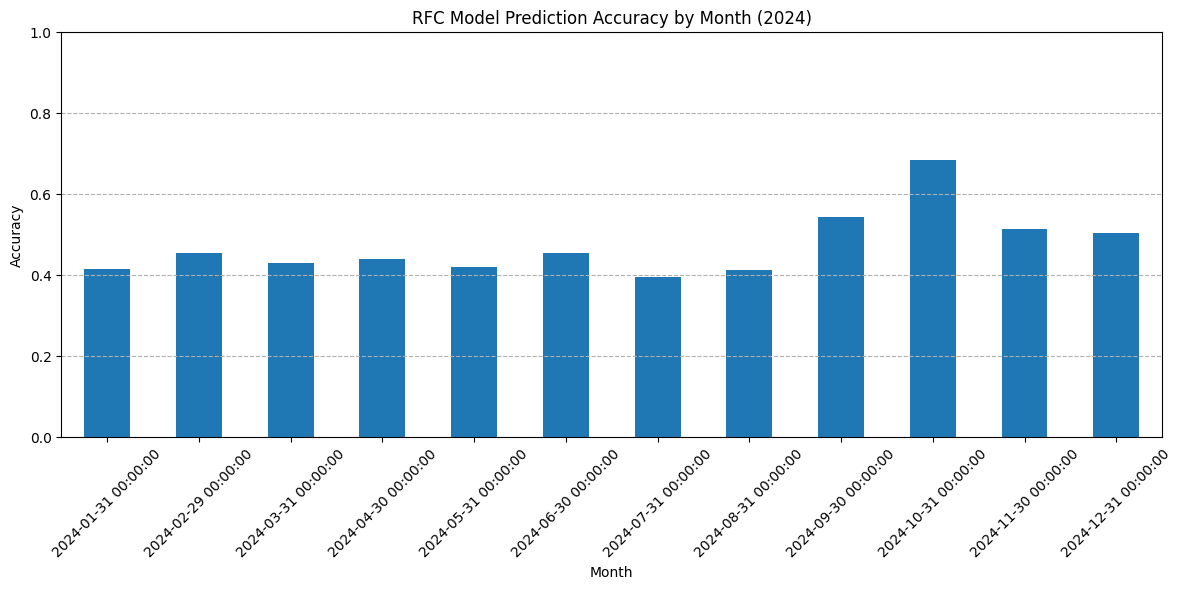


Sample of Test Results with Predictions:
                     target  predicted_class actual_label predicted_label  \
2024-01-01 00:00:00       0                1      Bearish         Neutral   
2024-01-01 01:00:00       1                1      Neutral         Neutral   
2024-01-01 02:00:00       0                1      Bearish         Neutral   
2024-01-01 03:00:00       1                2      Neutral         Bullish   
2024-01-01 04:00:00       2                2      Bullish         Bullish   

                     prob_bearish  prob_neutral  prob_bullish  
2024-01-01 00:00:00      0.337952      0.401243      0.260805  
2024-01-01 01:00:00      0.288774      0.429878      0.281347  
2024-01-01 02:00:00      0.301253      0.424722      0.274026  
2024-01-01 03:00:00      0.300464      0.301997      0.397539  
2024-01-01 04:00:00      0.331289      0.305517      0.363194  


In [7]:
# Add predictions and probabilities to the test dataframe for analysis
df_test_results = df_test.copy()

df_test_results.loc[:, 'predicted_class'] = y_pred
df_test_results.loc[:, 'prob_bearish'] = y_pred_proba[:, 0]
df_test_results.loc[:, 'prob_neutral'] = y_pred_proba[:, 1]
df_test_results.loc[:, 'prob_bullish'] = y_pred_proba[:, 2]

# Map numerical target/prediction to labels for clarity
target_map = {0: 'Bearish', 1: 'Neutral', 2: 'Bullish'}
df_test_results.loc[:, 'actual_label'] = df_test_results['target'].map(target_map)
df_test_results.loc[:, 'predicted_label'] = df_test_results['predicted_class'].map(target_map)

# Calculate if the prediction was correct
df_test_results.loc[:, 'correct_prediction'] = (df_test_results['target'] == df_test_results['predicted_class']).astype(int)

# --- Monthly Accuracy Analysis ---
if isinstance(df_test_results.index, pd.DatetimeIndex):
    monthly_accuracy = df_test_results.resample('ME')['correct_prediction'].mean()
    
    print("\nMonthly Accuracy (2024 Test Set):")
    print(monthly_accuracy)
    
    plt.figure(figsize=(12, 6))
    monthly_accuracy.plot(kind='bar')
    plt.title('RFC Model Prediction Accuracy by Month (2024)')
    plt.ylabel('Accuracy')
    plt.xlabel('Month')
    plt.xticks(rotation=45)
    plt.ylim(0, 1) # Set y-axis limits for better comparison
    plt.grid(axis='y', linestyle='--')
    plt.tight_layout()
    plt.show()
else:
    print("Index is not DatetimeIndex. Skipping monthly accuracy plot.")

# Display some results
print("\nSample of Test Results with Predictions:")
print(df_test_results[['target', 'predicted_class', 'actual_label', 'predicted_label', 'prob_bearish', 'prob_neutral', 'prob_bullish']].head())

### Backtesting the Strategy

Sample signals for backtesting:
                     target  predicted_class  signal
2024-01-01 00:00:00       0                1       0
2024-01-01 01:00:00       1                1       0
2024-01-01 02:00:00       0                1       0
2024-01-01 03:00:00       1                2       1
2024-01-01 04:00:00       2                2       1

Predicted signal distribution for backtest:
signal
-1    4344
 1    2653
 0    1787
Name: count, dtype: int64

Running backtest...
Overall Annual Return: 46.81%
Overall Annual Sharpe Ratio: 1.0245
Maximum Drawdown: -24.95 %
Alpha: 0.9096
Beta: -0.1513

Yearly Metrics:
   year  yearly_return  yearly_std  yearly_beta  yearly_alpha  yearly_sharpe
0  2024       0.468071    0.494025    -0.151251      0.646923       1.024494


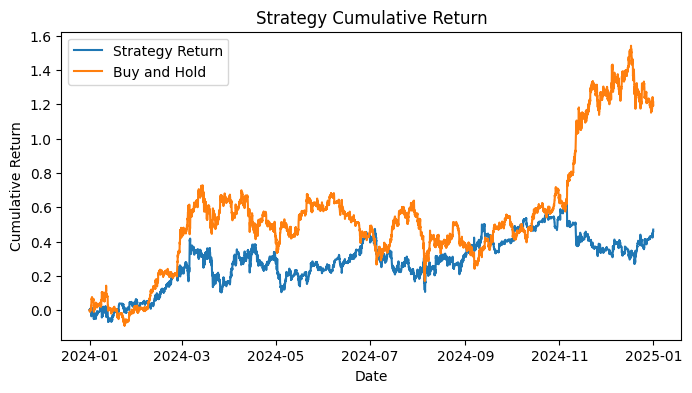

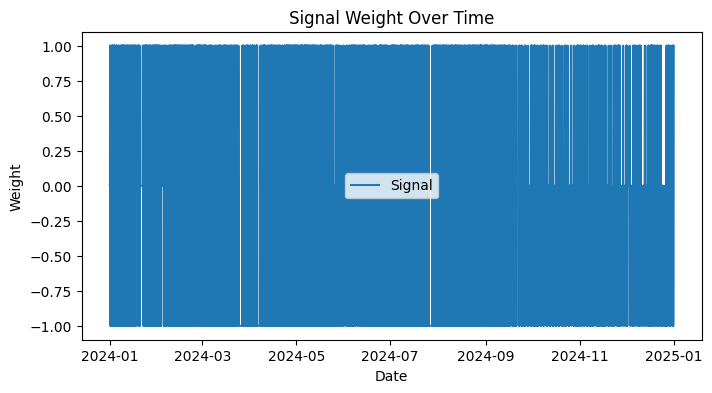

In [ ]:
# Prepare dataframe for backtesting
df_backtest = df_test_results.copy()

# Map predicted class to trading signal: 0 -> -1 (Short), 1 -> 0 (Neutral), 2 -> 1 (Long)
df_backtest['signal'] = df_backtest['predicted_class'] - 1

# Display the first few rows with the new signal column
print("Sample signals for backtesting:")
print(df_backtest[['target', 'predicted_class', 'signal']].head())

# Check the distribution of the generated signals
print("\nPredicted signal distribution for backtest:")
print(df_backtest['signal'].value_counts())

run_backtest(df_backtest, freq='h')